In [1]:
#importing packages
import requests
import json
import pandas as pd
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
import numpy as np
import os

# Data Acquisition

## Specifying API endpoints to get data for Wikipedia pageviews. The legacy API retired in July 2016, and the more accurate pageviews started from July 2015. 
### Start Date: January 2008 
### End Date: September 2018
### Aggregation: Monthly

In [2]:
# api endpoints for legacy pagecounts and pageviews
pagecount_mobile = 'https://wikimedia.org/api/rest_v1/metrics/legacy/pagecounts/aggregate/de.wikipedia.org/mobile-site/monthly/'
pagecount_desktop = 'https://wikimedia.org/api/rest_v1/metrics/legacy/pagecounts/aggregate/de.wikipedia.org/desktop-site/monthly/'
pageviews_mobile_web = 'https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/de.wikipedia.org/mobile-web/user/monthly/'
pageviews_mobile_app = 'https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/de.wikipedia.org/mobile-app/user/monthly/'
pageviews_desktop = 'https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/de.wikipedia.org/desktop/user/monthly/'

In [3]:
# dictionary for all url's of the endpoints
dict_url = {
        'pagecount_mobile': pagecount_mobile,
        'pagecount_desktop': pagecount_desktop,
        'pageviews_mobile_web': pageviews_mobile_web,
        'pageviews_mobile_app': pageviews_mobile_app,
        'pageviews_desktop': pageviews_desktop
}

In [4]:
# timestamp is required in a YYYYMMDDHH format
start_ts = '2008010100'
end_ts = '2018093000'

In [5]:
# getting current working directory
cwd = os.getcwd()

In [6]:
# fetching data from the APIs between the specified dates
for api_name, api_url in dict_url.items():
    try:
        result = requests.get(api_url + start_ts + "/" + end_ts)
        # writing to a file on the disk (and creating one if none exists)
        with open(cwd + '/raw_data/' + api_name + '_' + start_ts[:6] + '-' + end_ts[:6] + '.json', 'w') as json_file:
            json_file.write(json.dumps(json.loads(result.content.decode('utf-8'))))
    # catching exception if hitting url goes awry
    except requests.exceptions.RequestException as e:
        print (e)

# Data Processing

### Processing involves flattening the json input to get a tabular structure loaded into a pandas dataframe. An empty pandas dataframe with zero values for all possible year-month values is created to make all the datasets of the same dimension. Views from Pageviews Mobile (Web + App) merged to be Pageviews Mobile.  

In [7]:
# function to convert json to pandas dataframe
def json_to_df(json_file_path):
    # reading the json file
    df = pd.read_json(cwd + '/raw_data/' + json_file_path)
    # flattening the file to make columns
    flatten_df = df.join(json_normalize(df["items"].tolist()).
                         add_prefix("items_")).drop(["items"], axis=1)
    # split the timestamp column into seperate year and month columns
    flatten_df['year'] = flatten_df['items_timestamp'].apply(lambda x: x[:4])
    flatten_df['month'] = flatten_df['items_timestamp'].apply(lambda x: x[4:6])
    # rename views/counts to num_views
    if 'items_views' in flatten_df.columns:
        flatten_df.rename(columns={'items_views': 'num_views'}, inplace=True)
    elif 'items_count' in flatten_df.columns:
        flatten_df.rename(columns={'items_count': 'num_views'}, inplace=True)
    # getting only user views, discarding crawlers for pageviews
    if 'items_agent' in flatten_df.columns:
        flatten_df = flatten_df.loc[flatten_df['items_agent'] == 'user']
    # subsetting the dataframe to get only relevant columns
    df = flatten_df[['year', 'month', 'num_views']]
    return (df)

In [8]:
# getting a dataframe with empty year month values

# initialize an empty dataframe
empty_df = pd.DataFrame()
# getting a list of all year values
year_list = list(range(2008, 2019))
# iterating through year values
month_seq = list(range(1, 13))
for y in year_list:
    data = pd.DataFrame()
    data['year'] = [y] * 12
    data['month'] = month_seq
    # formatting both columns into strings
    data['year'] = data['year'].apply(lambda x: str(x))
    data['month'] = data['month'].apply(lambda x: format(x, '02d'))
    empty_df = empty_df.append(data)

# creating an empty num_views column
empty_df['num_views'] = 0

# removing the last 3 rows (last 3 months of 2018)
empty_df = empty_df[:-3]
# resetting index
empty_df = empty_df.reset_index(drop = True)

In [9]:
# writing a function to fill the df for the entire length of time
def fill_df(in_df):
    df = pd.merge(empty_df, in_df, on = ['year', 'month'], how = 'outer')
    # replacing NANs
    df = df.fillna(0)
    # converting the filled value to integer
    df['num_views_y'] = df['num_views_y'].apply(lambda x: int(x))
    # getting the final values of num_views
    df['num_views'] = df['num_views_x'] + df['num_views_y']
    # subsetting the dataset
    df = df[['year', 'month', 'num_views']]
    return (df)

In [10]:
# load data from pageviews api
pageviews_mobile_web = json_to_df('pageviews_mobile_web_200801-201809.json')
pageviews_mobile_app = json_to_df('pageviews_mobile_app_200801-201809.json')

In [11]:
# combining data from the pageviews mobile api
# merging the two dataframes 
pageviews_mobile = pd.merge(pageviews_mobile_web, pageviews_mobile_app, on = ['year','month'])
# getting the total mobile views
pageviews_mobile['num_views'] = pageviews_mobile['num_views_x'] + pageviews_mobile['num_views_y']
# subsetting the dataframe
pageviews_mobile = pageviews_mobile[['year', 'month', 'num_views']]

In [12]:
# getting all other dataframes
# pageview desktop
pageviews_desktop = json_to_df('pageviews_desktop_200801-201809.json')
# pagecount desktop
pagecount_desktop = json_to_df('pagecount_desktop_200801-201809.json')
# pagecount_mobile
pagecount_mobile = json_to_df('pagecount_mobile_200801-201809.json')

In [13]:
# getting all datasets "filled"
pageviews_mobile = fill_df(pageviews_mobile)
pageviews_desktop = fill_df(pageviews_desktop)
pagecount_desktop = fill_df(pagecount_desktop)
pagecount_mobile = fill_df(pagecount_mobile)

In [14]:
# renaming the num_views column
pageviews_mobile.rename(columns={'num_views': 'pageview_mobile_views'}, inplace=True)
# renaming the num_views column
pageviews_desktop.rename(columns={'num_views': 'pageview_desktop_views'}, inplace=True)
# renaming the num_views column
pagecount_desktop.rename(columns={'num_views': 'pagecount_desktop_views'}, inplace=True)
# renaming the num_views column
pagecount_mobile.rename(columns={'num_views': 'pagecount_mobile_views'}, inplace=True)

In [15]:
# concatenating the dataframes
frames = [pageviews_mobile, pageviews_desktop, pagecount_desktop, pagecount_mobile]
final_df = pd.concat(frames, axis=1)

# multiple column names with the same name, make them different
col_names = pd.Series(final_df.columns)
for dup in final_df.columns.get_duplicates(): 
    col_names[final_df.columns.get_loc(dup)] = [dup + '.' + str(d_idx) if d_idx != 0 else dup for d_idx in range(final_df.columns.get_loc(dup).sum())]
final_df.columns = col_names

# subsetting the columns
final_df = final_df[['year', 'month', 'pageview_mobile_views', 'pageview_desktop_views',
                    'pagecount_desktop_views', 'pagecount_mobile_views']]
# creating 2 new columns for totals
final_df['pagecount_all_views'] = final_df['pagecount_desktop_views'] + final_df['pagecount_mobile_views']
final_df['pageview_all_views'] = final_df['pageview_desktop_views'] + final_df['pageview_mobile_views']

In [16]:
# saving dataframe to a csv file
final_df.to_csv(cwd + '/clean_data/' + 'en-wikipedia_traffic_200801-201709.csv',index=False)

In [17]:
# sample header of the final file
final_df.head(5)

,year,month,pageview_mobile_views,pageview_desktop_views,pagecount_desktop_views,pagecount_mobile_views,pagecount_all_views,pageview_all_views
0,2008,01,0,0,863575077,0,863575077,0
1,2008,02,0,0,805618770,0,805618770,0
2,2008,03,0,0,821957233,0,821957233,0
3,2008,04,0,0,844357513,0,844357513,0
4,2008,05,0,0,827713709,0,827713709,0


# Data Analysis

In [18]:
# converting the dataframe series into a time series for plotting
# getting the start date for every year+month combination
final_df['date'] = final_df['year'] + "-" + final_df['month'] + "-01"
# list of timeseries
ts_list = [(final_df['pagecount_all_views'] + final_df['pageview_all_views']).tolist(),
          (final_df['pagecount_desktop_views'] + final_df['pageview_desktop_views']).tolist(),
          (final_df['pagecount_mobile_views'] + final_df['pageview_mobile_views']).tolist()]
# time series for plotting
ts_plot = pd.DataFrame(np.array(ts_list).T, 
                       index = pd.date_range(start = '2008-01-01', end = '2018-10-01', freq = 'M'),
                       columns = ['total','main site','mobile site'])

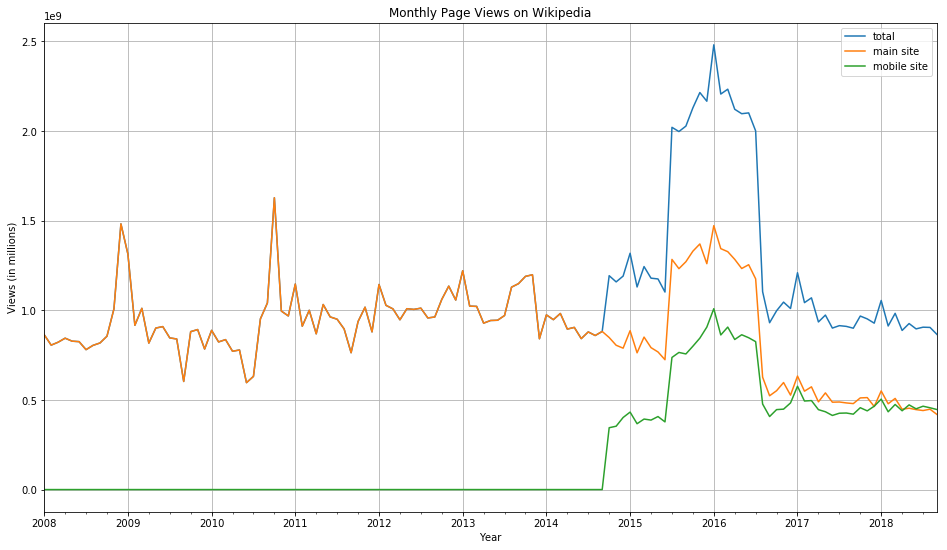

In [19]:
# plotting the graph
axis = ts_plot.plot(title = 'Monthly Page Views on Wikipedia')
axis.set_xlabel("Year")
axis.set_ylabel("Views (in millions)")
fig = axis.get_figure()
fig.set_size_inches(16, 9)
plt.grid(True)
fig

### Note: The bump around 2016 is due to the overlapping traffic data from the two different API endpoints.

In [20]:
# saving the plot on the disk
plt.savefig(cwd + '/results/' + 'wikipedia_pageviews.png')